In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path=r'{PATH_HERE}/Divine-Vision-Deep-Learning-Based-Image-Caption-Generation-for-Indian-Deities-master/DATASET/Images'

In [3]:
data = pd.read_csv(r"{PATH_HERE}/Divine-Vision-Deep-Learning-Based-Image-Caption-Generation-for-Indian-Deities-master\DATASET/captions.txt", on_bad_lines = 'warn')
data.head()

,image,caption
0,image_1.jpeg,God Brahma painting in sitting posture.
1,image_1.jpeg,Hindu deity brahma giving blessing .
2,image_1.jpeg,Lord Brahma painting with multiple heads and h...
3,image_1.jpeg,God Brahma drawing wearing lots of jewellary .
4,image_1.jpeg,God Brahma portrait with white beared and mous...


In [4]:
def text_preprocessing(data):
    # Convert 'caption' column to strings
    data['caption'] = data['caption'].astype(str)
    # Apply lowercase transformation
    data['caption'] = data['caption'].str.lower()
    # Remove non-alphanumeric characters
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
    # Remove extra whitespaces
    data['caption'] = data['caption'].str.strip()
    # Remove words with length 1
    data['caption'] = data['caption'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
    # Add startseq and endseq tokens
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

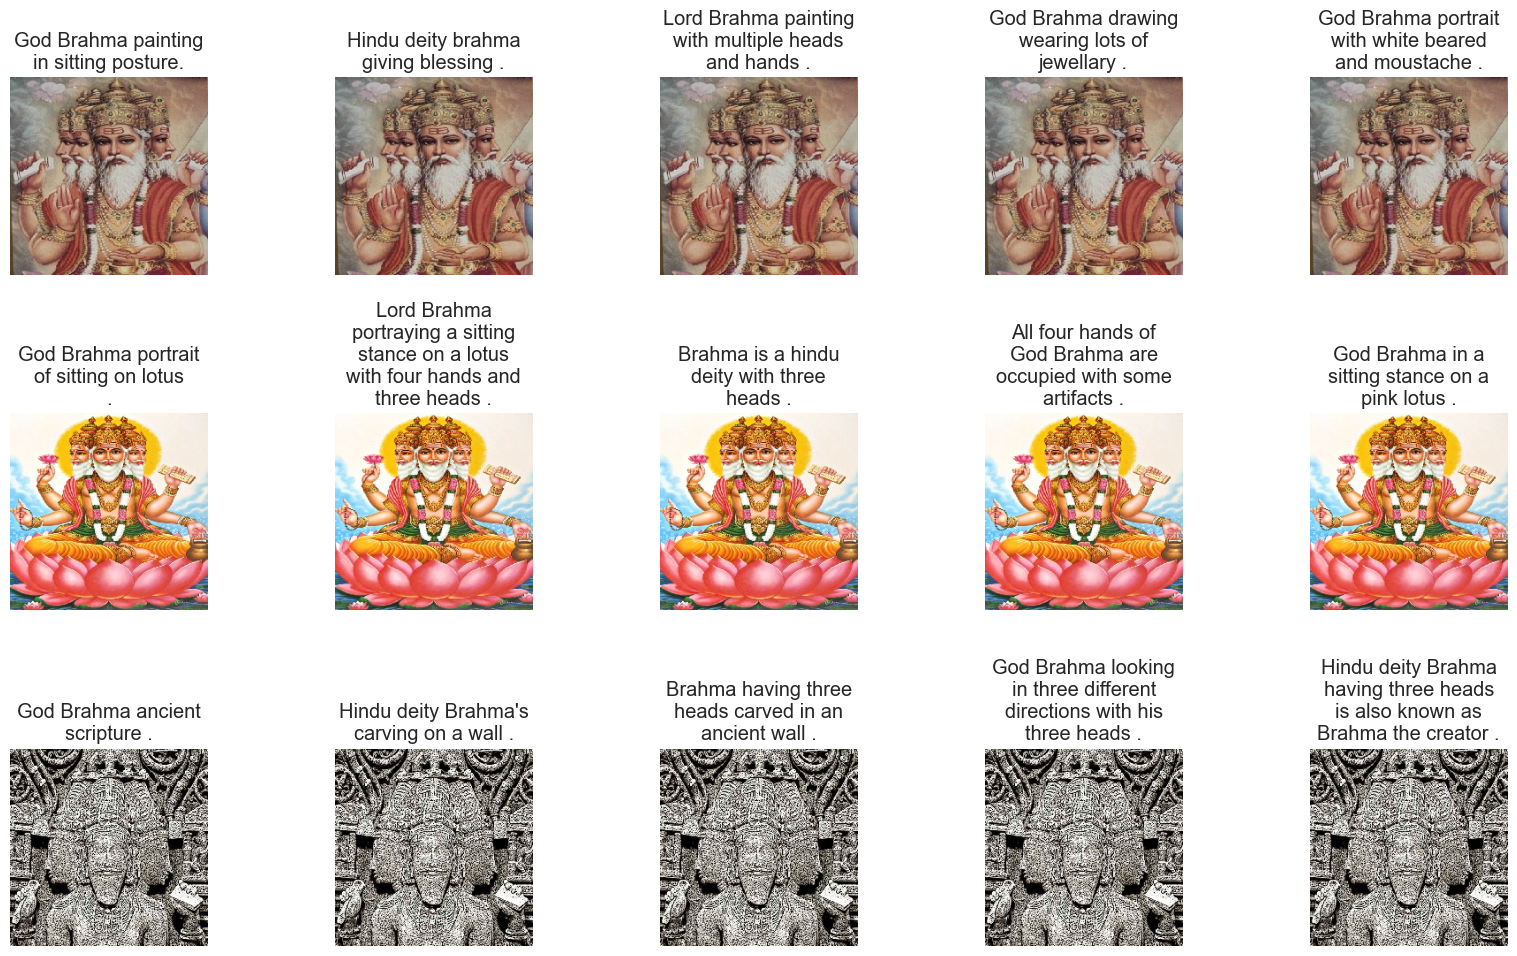

In [5]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image_path = os.path.join(images_directory, temp_df.image[i])
        image = readImage(image_path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


# Load your DataFrame from a CSV file or another source
temp_df = pd.read_csv(r"{PATH_HERE}/Divine-Vision-Deep-Learning-Based-Image-Caption-Generation-for-Indian-Deities-master\DATASET/captions.txt", on_bad_lines = 'warn')

# Continue with the rest of the code
images_directory = r'{PATH_HERE}/Divine-Vision-Deep-Learning-Based-Image-Caption-Generation-for-Indian-Deities-master/DATASET/Images'
display_images(temp_df)


In [6]:
data = text_preprocessing(data)
data['caption'].apply(type)
captions = data['caption'].tolist()
captions[:10]

['startseq god brahma painting in sitting posture endseq',
 'startseq hindu deity brahma giving blessing endseq',
 'startseq lord brahma painting with multiple heads and hands endseq',
 'startseq god brahma drawing wearing lots of jewellary endseq',
 'startseq god brahma portrait with white beared and moustache endseq',
 'startseq god brahma portrait of sitting on lotus endseq',
 'startseq lord brahma portraying sitting stance on lotus with four hands and three heads endseq',
 'startseq brahma is hindu deity with three heads endseq',
 'startseq all four hands of god brahma are occupied with some artifacts endseq',
 'startseq god brahma in sitting stance on pink lotus endseq']

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 86, 19, 12, 71, 85, 2]

In [8]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|████████████████████████████████████████████████████████████████████████████████| 869/869 [01:08<00:00, 12.73it/s]


In [9]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [10]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
from tensorflow.keras.utils import plot_model

In [11]:
caption_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         491,776 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 256)            │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 32, 256)           │         184,576 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 33, 256)           │               0 │ reshape[0][0],             │
│                               │                           │                 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dropout[0][0], dense[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 721)               │          93,009 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,327,569 (5.06 MB)

 Trainable params: 1,327,569 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [13]:
model_name = "model2.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [14]:
history = caption_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 5.8547
Epoch 1: val_loss improved from inf to 4.53789, saving model to model2.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 646ms/step - loss: 5.8448 - val_loss: 4.5379 - learning_rate: 0.0010
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 4.5883
Epoch 2: val_loss improved from 4.53789 to 4.00322, saving model to model2.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 4.5858 - val_loss: 4.0032 - learning_rate: 0.0010
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 4.0668
Epoch 3: val_loss improved from 4.00322 to 3.50896, saving model to model2.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 4.0637 - val_loss: 3.5090 - learning_rate: 0.0010
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 3.5069
Epoch 4: val_loss improved from 3.50896 to 3.09144, saving model to model2.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 3.5055 - val_loss: 3.0914 - learning_rate: 0.0010
Epoch 5/5
46/46 ━━━

In [15]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [16]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [17]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [18]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

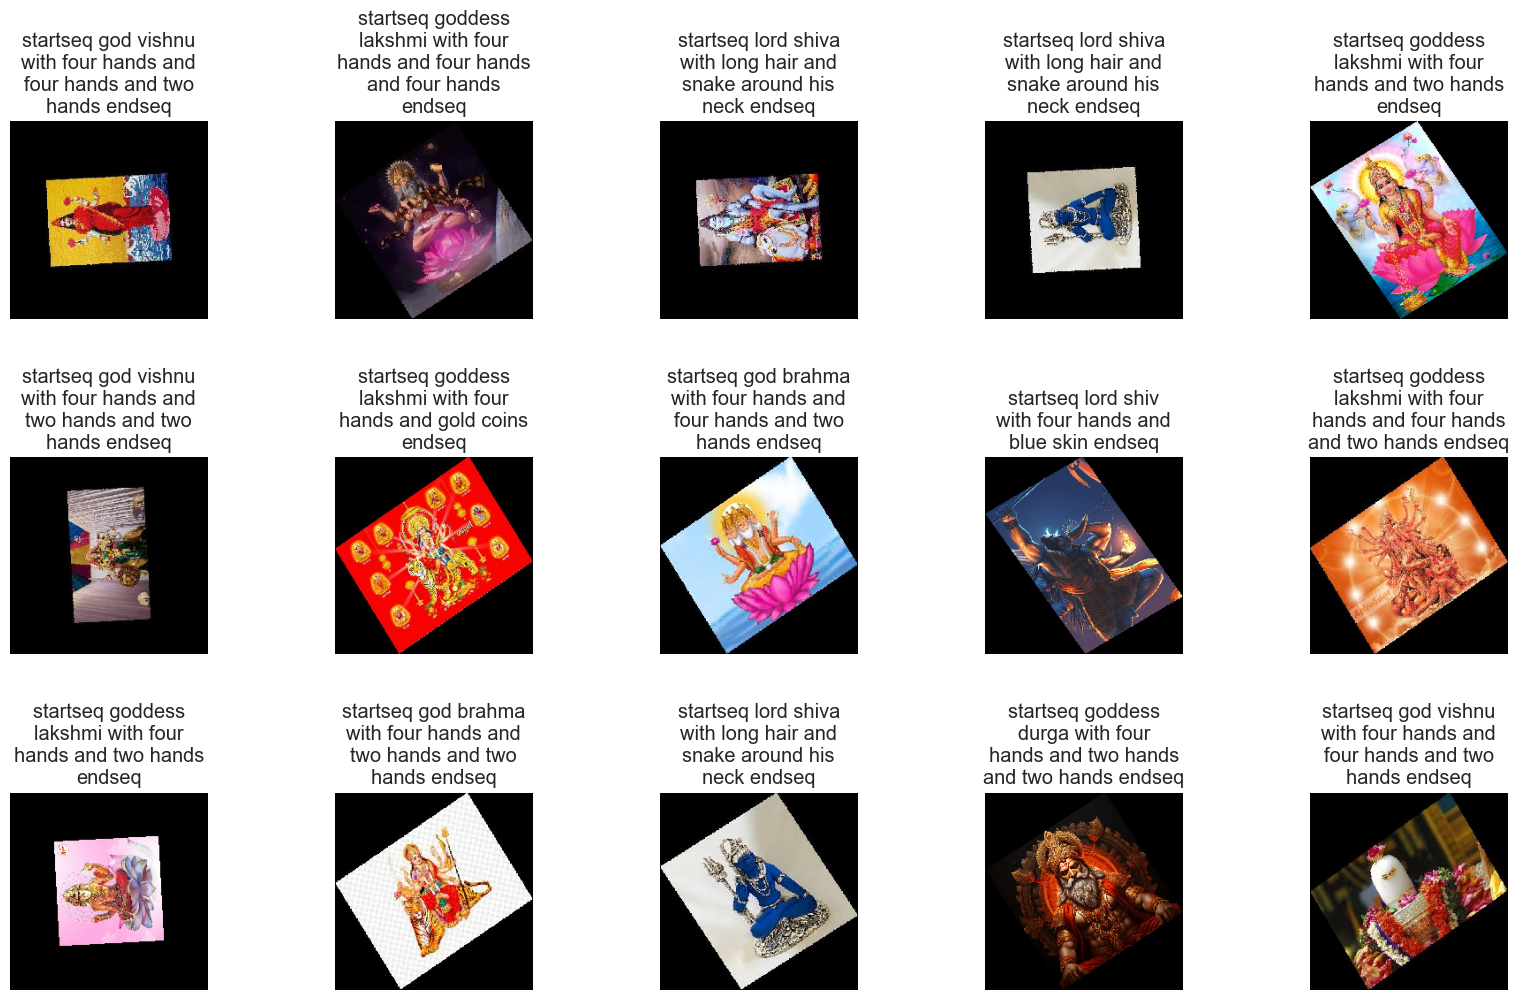

In [19]:
display_images(samples)

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tabulate import tabulate


def calculate_bleu(reference, candidate, n=2):
    reference = [reference.split()]
    candidate = candidate.split()
    smooth = SmoothingFunction().method1  # Define smoothing function

    # Calculate BLEU score with smoothing and specify n-gram
    bleu_score = sentence_bleu(reference, candidate, weights=(1.0 / n,) * n, smoothing_function=smooth)

    return bleu_score



def evaluate_bleu(model, data, tokenizer, max_length, features):
    bleu1_scores, bleu2_scores = [], []

    for index, record in data.iterrows():
        reference_caption = record['caption']
        predicted_caption = predict_caption(model, record['image'], tokenizer, max_length, features)
        
        bleu1_score = calculate_bleu(reference_caption, predicted_caption, n=1)
        bleu2_score = calculate_bleu(reference_caption, predicted_caption, n=2)
        
        bleu1_scores.append(bleu1_score)
        bleu2_scores.append(bleu2_score)

    average_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    average_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
    
    return average_bleu1, average_bleu2


average_bleu1, average_bleu2 = evaluate_bleu(caption_model, test, tokenizer, max_length, features)

table = tabulate({'BLEU-1': [average_bleu1], 'BLEU-2': [average_bleu2]}, headers='keys', tablefmt='pretty')


In [ ]:
print(table)

In [ ]:
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Initialize lists to store ROUGE scores
rouge1_scores = []
rougeL_scores = []

for index, record in test.iterrows():
    actual_caption = word_tokenize(record['caption'])  # Tokenize actual caption
    predicted_caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    predicted_caption = word_tokenize(predicted_caption)  # Tokenize predicted caption

    # Calculate ROUGE scores
    rouge_scores = rouge_scorer.score(' '.join(actual_caption), ' '.join(predicted_caption))
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average ROUGE-1 score:", avg_rouge1)
print("Average ROUGE-L score:", avg_rougeL)


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
Average ROUGE-1 score: 0.34368486241201185
Average ROUGE-L score: 0.33708849641590544


In [ ]:
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

# Initialize lists to store METEOR scores
meteor_scores = []

for index, record in test.iterrows():
    actual_caption = word_tokenize(record['caption'])  # Tokenize actual caption
    predicted_caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    predicted_caption = word_tokenize(predicted_caption)  # Tokenize predicted caption

    # Calculate METEOR score
    meteor_scores.append(meteor_score([actual_caption], predicted_caption))

# Calculate average METEOR score
avg_meteor = sum(meteor_scores) / len(meteor_scores)

print("Average METEOR score:", avg_meteor)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step
Average METEOR score: 0.24017115697976021


In [ ]:
print(nltk.__version__)